# テストプログラム

ライブラリのインポート

関数定義

コンフィグファイルのロード


In [1]:
# import library
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import time
import yaml
import sys
import os
import h5py
import matplotlib.pyplot as plt
import cv2

from datasetgenerator.DatasetGenerator import DatasetGenerator

In [2]:
# make function
def makedir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def print_and_file_write(file, string):
    file.write(string + "\n")
    print(string)

In [3]:
# open congig yaml file.
print("open config file...")
with open("config.yaml") as file:
    print("complete!")
    yml = yaml.safe_load(file)

open config file...
complete!


---

## データセット

データセットのロード

データ数の表示

データをプロットする

In [4]:
# Dataset Generator loadding.
dataset = DatasetGenerator()
print("test dataset loading...")
print("--------- dataset ---------")
if yml["testresourcedata"]["readdata"] == "text" or yml["testresourcedata"]["readdata"] == "TEXT":
    input, answer = dataset.text_dataset(yml["testresourcedata"]["resourcepath"])
    datacount = dataset.text_datacounter(yml["testresourcedata"]["resourcepath"])
elif yml["testresourcedata"]["readdata"] == "onefolder" or yml["testresourcedata"]["readdata"] == "Onefolder":
    input, answer = dataset.onefolder_dataet(yml["testresourcedata"]["resourcepath"])
    datacount = dataset.onefolder_datacounter(yml["testresourcedata"]["resourcepath"])
elif yml["testresourcedata"]["readdata"] == "folder" or yml["testresourcedata"]["readdata"] == "Folder":
    input, answer = dataset.folder_dataset(yml["testresourcedata"]["resourcepath"])
    datacount = dataset.folder_datacounter(yml["testresourcedata"]["resourcepath"])
else:
    print("It appears that you have selected a data loader that is not specified. Stops the program.")
    exit(1)
print("test data : ", datacount)
print("---------------------------")
print("---------- class ----------")
classes = yml["Resourcedata"]["classes"]
for c in classes:
    print(c)
print("---------------------------")

test dataset loading...
--------- dataset ---------
test data :  810
---------------------------
---------- class ----------
choki
goo
paa
---------------------------


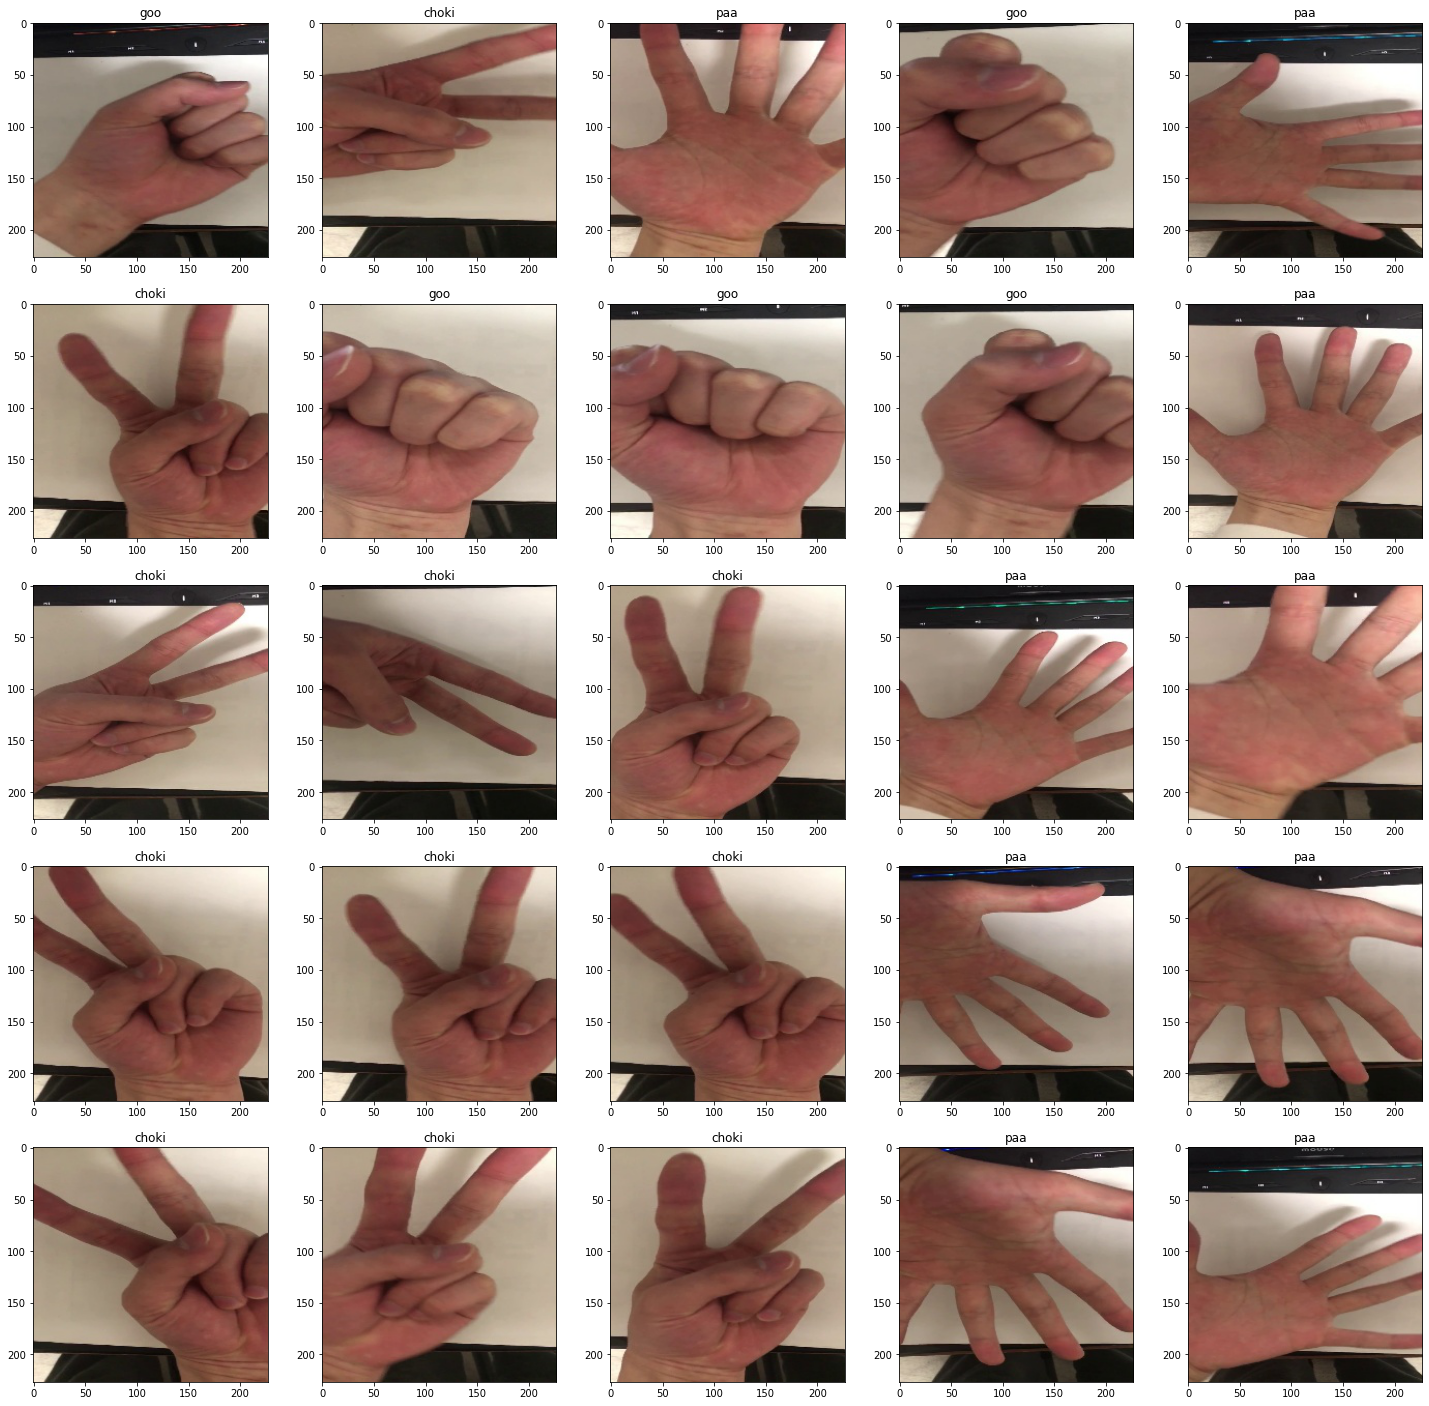

In [5]:
# plot dataset
xdata, ydata = [], []

# load dataset... and read PIL image.
for x in range(25):
    rand_num=np.random.randint(0,datacount)
    xdata.append(img_to_array(load_img(input[rand_num], color_mode="rgb", target_size=(yml["testresourcedata"]["img_row"], yml["testresourcedata"]["img_col"])))/255)
    ydata.append(answer[rand_num])

# image plot
plt.figure(figsize=(25,25), facecolor='white')
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(xdata[i])
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.title(classes[int(ydata[i])])
# show img
plt.show()

---

## モデル定義

loadmodel(この部分をどうするか迷ってます。)
### 現在はloadmodelを行っているが構成のロードはjsonなどで行うべき？


In [6]:
print("---------  model  ---------")
# open congig yaml file.
model = load_model(yml["TESTModel"]["path"] + yml["TESTModel"]["weight_path"])
print("Load model weight...")
model.load_weights(yml["TESTModel"]["path"] + yml["TESTModel"]["weight_path"])
model.summary()
print("---------------------------")

---------  model  ---------
Load model weight...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 57, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 96)        9312      
_________________________________________________________________
activation (Activation)      (None, 15, 15, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_n

## テストの実行

一つずつ1batchでpredictをかけてあっているのかどうかをscikitlearnのclassification reportを行い検証する。
(効率的には結構悪いことをしている。改善の余地あり。)
imageのbatchサイズ用のreshapeは変更した方がいいかも...

In [7]:
predict_list, ans_list, predict_rawdata = [], [], []

for count, (x, ans) in enumerate(zip(input, answer)):
    # image file open.
    try:
        # I'll load the image, and if it doesn't work, I'll terminate the program.
        image = img_to_array(load_img(x, color_mode="rgb", target_size=(yml["testresourcedata"]["img_row"], yml["testresourcedata"]["img_col"])))
        # Normalize image.
        image /= 255.
    except Exception as e:
        print("Failed to load data.")
        print("ERROR : ", e)
        exit(1)

    # model predict => pred_label
    predict = model.predict(np.asarray([image], np.float32), batch_size=1)
    predict_rawdata.append(predict)
    
    predict_list.append(np.argmax(predict))
    # ans => answer list
    ans_list.append(int(ans))

    # Raw data of predicted values
    #print(predict)

In [8]:
# calassification report. and write csv

result = classification_report(ans_list, predict_list, target_names = classes, output_dict=True)
print("--------------< result >--------------")
print(classification_report(ans_list, predict_list, target_names = yml["Resourcedata"]["classes"]))
print("--------------------------------------")
class_pd = pd.DataFrame(result)
class_pd.to_csv(yml["TESTModel"]["path"] + "/classification_report.csv")

--------------< result >--------------
              precision    recall  f1-score   support

       choki       1.00      0.99      0.99       300
         goo       0.73      1.00      0.84       270
         paa       1.00      0.59      0.74       240

    accuracy                           0.88       810
   macro avg       0.91      0.86      0.86       810
weighted avg       0.91      0.88      0.87       810

--------------------------------------


## 正解リストと不正解リストの作成

正解と不正解のリストを作成
それぞれのリストはcsvで出力を行う。


In [9]:
# correct list and uncorrect list creat.
print("correct and fail predict list create...")

correct_list, uncorrect_list = [], []
for (image_path, prd, ans, raw_prd) in zip(input, predict_list, ans_list, predict_rawdata):
    if ans == prd:
        correct_list.append([image_path, ans, prd, str(raw_prd.tolist())])
    else:
        uncorrect_list.append([image_path, ans, prd, str(raw_prd.tolist())])
correct_df = pd.DataFrame(correct_list, columns=['inputdata', 'answer', 'predict', 'predict_rawdata'],index=range(len(correct_list)))
uncorrect_df = pd.DataFrame(uncorrect_list, columns=['inputdata', 'answer', 'predict', 'predict_rawdata'],index=range(len(uncorrect_list)))

#print(correct_df)
#print(uncorrect_df)

print("result write csv...")
correct_df.to_csv(yml["TESTModel"]["path"] + "/predict_correct_list.csv")
uncorrect_df.to_csv(yml["TESTModel"]["path"] + "/predict_uncorrect_list.csv")
print("complate")

correct and fail predict list create...
result write csv...
complate


## 正答率の詳細表示

各カテゴリにおいてどのカテゴリがどの回答をしているのかを算出していく
これはテキストに出力

In [10]:
# show detail result. 
# Indicate which items are being answered and by how much.
category_result = [0] * len(classes)
class_count = 0

# for result write file.
with open(yml["TESTModel"]["path"] + "/predict_result.txt", mode='w') as f:
    print_and_file_write(f, "data count : {}".format(datacount))

    for category in range(len(classes)):
        print_and_file_write(f, "============{}================".format(classes[category]))
        # Check your predict and answers.
        for (prd, ans) in zip(predict_list, ans_list):
            # If the answer and the category (rotating in a for loop) match, add the number of categories inferred
            if category == ans:
                category_result[prd] += 1
                class_count += 1
        # Show the results of the inference.
        for c, prd_count in enumerate(category_result):
            print_and_file_write(f ,"answer = {}, predict {} => {}".format(classes[category], classes[c], prd_count))
        # Show the number of each category
        print_and_file_write(f, "class data count : {}".format(class_count))
        # reset result list. and reset class count
        category_result = [0] * len(classes)
        class_count = 0 
    print_and_file_write(f, "=====================================")

data count : 810
============choki================
answer = choki, predict choki => 297
answer = choki, predict goo => 3
answer = choki, predict paa => 0
class data count : 300
============goo================
answer = goo, predict choki => 0
answer = goo, predict goo => 270
answer = goo, predict paa => 0
class data count : 270
============paa================
answer = paa, predict choki => 0
answer = paa, predict goo => 98
answer = paa, predict paa => 142
class data count : 240


## 回答のフィルター機能

推論と回答のクラスを入力し実行することでそれらに一致するものの画像ファイル群を出力する。

In [11]:
# show detail result. 
# Indicate which items are being answered and by how much.
category_result = [0] * len(classes)
class_count = 0

predict_index = "choki"
answer_index = "goo"
filename = "/filterresult.txt"

# Examine the index of a given category
predict_index = [i for i, cate in enumerate(classes) if cate == predict_index]
answer_index = [i for i, cate in enumerate(classes) if cate == answer_index]

# for result write file.
with open(yml["TESTModel"]["path"] + filename, mode='w') as f:
    # Check your predict and answers.
    for (img, prd, ans) in zip(input, predict_list, ans_list):
        # If the answer and the category (rotating in a for loop) match, add the number of categories inferred
        if ans == answer_index[0] and prd == predict_index[0]:
            print_and_file_write(f, img)

## Gradcamの作成(heatmap)

    現在制作中

In [12]:
import pprint
from tensorflow.python.keras import backend as K 

In [13]:
names = [l.name for l in model.layers]
pprint.pprint(names, compact=True)

['conv2d', 'batch_normalization', 'conv2d_1', 'activation', 'max_pooling2d',
 'conv2d_2', 'batch_normalization_1', 'conv2d_3', 'activation_1',
 'max_pooling2d_1', 'conv2d_4', 'batch_normalization_2', 'conv2d_5',
 'activation_2', 'max_pooling2d_2', 'activation_3', 'dropout', 'conv2d_6',
 'batch_normalization_3', 'conv2d_7', 'activation_4',
 'global_average_pooling2d', 'activation_5']


レイヤー名を指定する。
入力画像を選択する

In [20]:
IMAGE_PATH = './dataset/goo/goo_001.jpg'
LAYER_NAME = 'conv2d_2'
CLASS = 0

In [21]:
img = load_img(IMAGE_PATH, target_size=(yml["testresourcedata"]["img_row"], yml["testresourcedata"]["img_col"]))
img = img_to_array(img)/255

In [22]:
# Create a graph that outputs target convolution and output
grad_model = Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CLASS]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (yml["testresourcedata"]["img_row"], yml["testresourcedata"]["img_col"]))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam.png', output_image)

True